In [1]:
## 모듈 로딩

## 경로 모듈
import sys
import os
import pickle
sys.path.append(r'C:\Users\KDP-50\OneDrive\바탕 화면\KDT_DYH\10.Natural_Language_Processing')

from Korpora import Korpora                         # Open Korean Dataset
from konlpy.tag import *                            # 형태소 분석기
import spacy                                        # 형태소 분석기

from nltk.tokenize import word_tokenize, sent_tokenize, wordpunct_tokenize
from torch.utils.data import Dataset, DataLoader    # Pytorch Dataset 관련 모듈
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import re
from konlpy.tag import *
from sklearn.model_selection import train_test_split

# Pytorch 관련 모듈
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import TensorDataset, DataLoader
from torchmetrics.classification import BinaryF1Score

from NLPmodules import classRNN
from NLPmodules import funcRNN

In [ ]:
# 데이터 준비
CSV='CSVgenitourinary.csv'
FILE_PATH='../Project/'

# 파일 불러와서 읽기
with open(FILE_PATH+CSV, mode='r', encoding='utf-8') as f:
    texts=f.read().splitlines()

In [3]:
texts

In [4]:
text_list=''.join(texts).split('.')

In [ ]:
text_list=''.join(texts).split('.')
strip_texts=[]
for text in text_list:
    if len(text):
        text = re.sub('[^ㄱ-ㅎ가-힣]',' ',text) # 순수 한글만 가져오기
        strip_texts.append(text.strip())

In [ ]:
pd.Series(strip_texts).to_csv('CSVgenitourinary(cleaning).csv', index=False, encoding='utf-8')

[1] 데이터 준비

In [7]:
# 감염성질환 데이터 (라벨: 0)
infeDF = pd.read_csv('infection.csv', names=['texts'], encoding='utf-8')
infeDF['labels']=0

In [8]:
# 호흡기질환 데이터 (라벨: 0)
respDF = pd.read_csv('text_data.csv', names=['texts'], encoding='utf-8')
respDF['labels']=0

In [9]:
# 소화기질환 데이터 (라벨: 0)
digeDF = pd.read_csv('sentenced_txt.csv', names=['texts'], encoding='utf-8')
digeDF['labels']=0

In [10]:
# 비뇨생식질환 데이터 (라벨: 1)
geniDF=pd.read_csv('CSVGeniPreg(cleaning).csv', names=['texts'], encoding='utf-8')
geniDF['labels']=1

In [11]:
print(len(infeDF),
len(respDF),
len(digeDF),
len(geniDF))

813 1109 975 562


In [12]:
plus1DF=pd.concat([infeDF[:187], respDF[:187]], ignore_index=True)
plus2DF=pd.concat([plus1DF, digeDF[:188]], ignore_index=True)

In [13]:
textDF=pd.concat([plus2DF, geniDF], ignore_index=True)

In [14]:
# textDF=pd.read_csv('CSVGeniPreg(cleaning).csv', names=['texts'], encoding='utf-8')
# textDF

In [15]:
# textDF['labels']=1
# textDF

In [16]:
textDF

,texts,labels
0,가스봉소직염,0
1,기종괴전,0
2,가스플레그몬이라고도 한다,0
3,근육 괴사와 독소로 인한 전신증상을 가져오는 중증 질환이다,0
4,등의 혐기성균이 근막하에서 증식하여 근 단백질을 분해해서 괴사에 이르게 하고 당...,0
...,...,...
1119,그 밖에 누공형성 요로 손상 수술창부 내막증 등도 있다,1
1120,특히 문제가 되는 것은 다음 분만을 할 때 자궁파열의 위험이 따르는 것이다,1
1121,그러므로 제왕절개 후 시기를 보아서 자궁난관조영을 시행하여 봉합 부위에 대한 조영제...,1
1122,분류수술식은 경복막 제왕절개술 복막외 제왕절개술 등의 보존적 제왕절개술 ...,1


In [ ]:
features = textDF['texts']
target = textDF['labels']

X_train, X_test, y_train, y_test = train_test_split(features,
                                                    target,
                                                    test_size = 0.2,
                                                    random_state = 42,
                                                    stratify = target)

In [18]:
## 언어 모델 설정
KO_MODEL = 'ko_core_news_sm'

# 꼬꼬마
kkma = Kkma()

In [19]:
# 불용어 경로
STOPWORDS = '../Data/basic_ko_stopwords.txt'
with open(STOPWORDS, mode='r', encoding='utf-8') as f:
    stopwords_ko = f.read().splitlines()

In [20]:
stopwords_ko

['ㄱ',
 'ㄴ',
 'ㄷ',
 'ㄹ',
 'ㅁ',
 'ㅂ',
 'ㅅ',
 'ㅇ',
 'ㅈ',
 'ㅊ',
 'ㅋ',
 'ㅌ',
 'ㅍ',
 'ㅎ',
 'ㄲ',
 'ㄸ',
 'ㅃ',
 'ㅆ',
 'ㅉ',
 'ㅏ',
 'ㅑ',
 'ㅓ',
 'ㅑ',
 'ㅗ',
 'ㅛ',
 'ㅜ',
 'ㅠ',
 'ㅡ',
 'ㅣ',
 'ㅐ',
 'ㅒ',
 'ㅔ',
 'ㅖ',
 'ㅚ',
 'ㅟ',
 'ㅘ',
 'ㅝ',
 'ㅢ',
 '가',
 '나',
 '다',
 '라',
 '마',
 '바',
 '사',
 '아',
 '자',
 '차',
 '카',
 '타',
 '파',
 '하',
 '까',
 '따',
 '빠',
 '싸',
 '짜',
 '갸',
 '냐',
 '댜',
 '랴',
 '먀',
 '뱌',
 '샤',
 '야',
 '쟈',
 '챠',
 '캬',
 '탸',
 '퍄',
 '햐',
 '꺄',
 '땨',
 '뺘',
 '쌰',
 '쨔',
 '거',
 '너',
 '더',
 '러',
 '머',
 '버',
 '서',
 '어',
 '저',
 '처',
 '커',
 '터',
 '퍼',
 '허',
 '꺼',
 '떠',
 '뻐',
 '써',
 '쩌',
 '겨',
 '녀',
 '뎌',
 '려',
 '며',
 '벼',
 '셔',
 '여',
 '져',
 '쳐',
 '켜',
 '텨',
 '펴',
 '혀',
 '껴',
 '뗘',
 '뼈',
 '쎠',
 '쪄',
 '고',
 '노',
 '도',
 '로',
 '모',
 '보',
 '소',
 '오',
 '조',
 '초',
 '코',
 '토',
 '포',
 '호',
 '꼬',
 '또',
 '뽀',
 '쏘',
 '쪼',
 '교',
 '뇨',
 '됴',
 '료',
 '묘',
 '뵤',
 '쇼',
 '요',
 '죠',
 '쵸',
 '쿄',
 '툐',
 '표',
 '효',
 '꾜',
 '뚀',
 '뾰',
 '쑈',
 '쬬',
 '구',
 '누',
 '두',
 '루',
 '무',
 '부',
 '수',
 '우',
 '주',
 '추',
 '쿠',
 '투',
 '푸',
 '후',
 '꾸'

In [21]:
class TextDataset(Dataset) :
    def __init__ (self, feature, label) :
        self.feature = feature
        self.label = label
        self.length = feature.shape[0]

    def __len__(self) :
        return self.length

    def __getitem__ (self, index) :
        return self.feature.iloc[index], self.label.iloc[index]

In [22]:
trainDS = TextDataset(X_train, y_train)
testDS = TextDataset(X_test, y_test)

[2] 토큰화

In [23]:
def generateToken(dataset):
    for text, label in dataset:
        token_list = []
        # 꼬꼬마 사용
        doc = kkma.morphs(text)

        for token in doc:
            # 불용어, 구두점 처리
            if (not token in stopwords_ko): # 불용어 제거 파트
                token_list.append(str(token))
        yield token_list

In [24]:
train_token_generator = generateToken(trainDS)
test_token_generator = generateToken(testDS)

In [25]:
def check_data(data):
    i = 0
    for _ in data:
        print(_)
        i += 1
        if i == 10:
            break

In [26]:
# check_data(train_token_generator)

[3] 단어사전 만들기

In [ ]:
# 제너레이터 호출
train_token_generator = generateToken(trainDS)

# 토큰을 키로 해서 빈도수 저장
token_freqs = {} # dict에서는 key값을 찾아봄

# 라인(줄)별 토큰을 읽어서 빈도 체크
for token_list in train_token_generator:
    # 불용어 재차 제거
    for token in token_list:
        # 카운트시, 토큰 key가 존재하지 않으면 key 추가
        if token not in token_freqs:
            token_freqs[token] = 1

        # 카운트시, 이미 존재하는 토큰 key는 1 증가
        else:
            token_freqs[token] += 1

print(token_freqs)

In [28]:
sorted_tokens = sorted(token_freqs.items(), key = lambda x: x[1], reverse = True)

In [29]:
check_data(sorted_tokens)

('ㄴ다', 472)
('있', 332)
('으로', 223)
('경우', 166)
('등', 141)
('것', 122)
('요법', 106)
('증상', 91)
('감염', 87)
('질환', 85)


In [30]:
PAD_TOKEN, OOV_TOKEN = 'pad', 'oov'

vocab = {PAD_TOKEN : 0, OOV_TOKEN : 1}

In [32]:
for index, token in enumerate(sorted_tokens, 2):
    vocab[token[0]] = index

In [33]:
check_data(vocab)

pad
oov
ㄴ다
있
으로
경우
등
것
요법
증상


[4] 수치화 하기

In [34]:
# 수치화 함수 생성
def numbering(generator):
    encoded_data = []

    for token_list in generator:
        L = []
        for token in token_list:
            if token in vocab:
                L.append(vocab[token])
            else:
                L.append(vocab[OOV_TOKEN])
        encoded_data.append(L)
    return encoded_data

In [35]:
# 제너레이터 호출

train_token_generator = generateToken(trainDS)
test_token_generator = generateToken(testDS)

train_ids = numbering(train_token_generator)
test_ids = numbering(test_token_generator)

check_data(train_ids)
print()
check_data(test_ids)

[1389, 166, 547, 1390, 548, 9, 1391, 263, 936, 7, 187, 110, 1392, 1393, 232, 264, 937, 87, 7, 187, 1394, 289, 680, 2]
[124, 8, 265, 66, 681, 150, 1395, 1396, 111, 449, 79, 1397, 14, 2]
[34, 188, 93, 327, 378, 139, 266, 25, 2]
[1398, 328, 290]
[379, 140, 72, 450, 43, 2]
[938, 45, 380, 291, 4, 682, 7]
[88, 59, 381, 151, 125, 1399, 2]
[683, 684, 685, 93, 549, 45, 16, 5, 3]
[98, 98, 98, 550, 451, 167, 551, 64, 329, 6, 98, 98, 98, 44, 452, 98, 98, 98, 98, 686, 77, 687, 77, 4, 939, 687, 77, 25, 11, 4, 1400, 19, 104, 30, 59, 189, 30, 59, 6, 30, 1401, 11, 382, 453, 1402, 1403, 1404, 1405, 233, 1406, 1407, 940, 1408, 1409, 65, 941, 6, 3]
[330, 234, 1410, 942, 49, 14, 383]

[1, 213]
[32, 66, 57, 4, 1133, 373, 1, 1862, 45, 130, 606, 45, 1895, 1060, 919, 1058, 1, 6, 3]
[521, 429, 1934, 3, 133, 5, 332, 1766, 135, 807, 2]
[296, 288, 144, 653, 537, 237, 49, 70, 1, 163, 216, 2207]
[1, 44, 11, 25, 1, 2331, 14, 1208, 90, 379, 6, 1226, 1796, 161, 211, 108, 28, 7, 4, 3, 58, 2123, 205, 1, 81, 379, 816, 440

[5] 패딩

In [36]:
# 패딩을 위한 최대 길이 측정
train_data_length = [len(data) for data in train_ids]
test_data_length = [len(data) for data in test_ids]

if max(train_data_length) >= max(test_data_length):
    MAX_LENGTH = max(train_data_length)
else:
    MAX_LENGTH = max(test_data_length)

MAX_LENGTH = 50

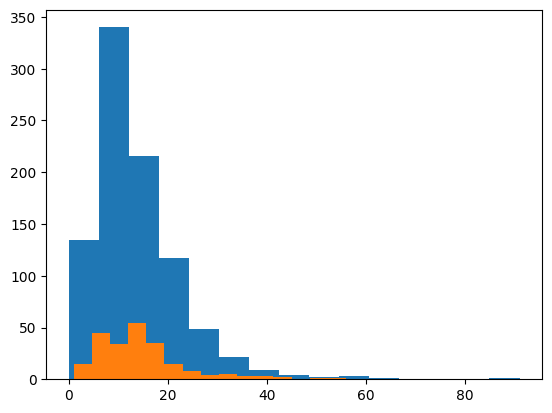

In [ ]:
import matplotlib.pyplot as plt
plt.hist(train_data_length, bins=15)
plt.hist(test_data_length, bins=15)
plt.show()

In [38]:
# 패딩 함수 생성
def padding(data_ids):
    for index, data in enumerate(data_ids):
        current_length = len(data)
        if current_length < MAX_LENGTH:
            data_ids[index] = data + ([vocab[PAD_TOKEN]] * (MAX_LENGTH - current_length))
        else:
            data_ids[index] = data[(current_length - MAX_LENGTH):]

In [40]:
padding(train_ids)
padding(test_ids)

for data in train_ids[:5]:
    print(len(data), data)

print()

# train 데이터셋으로 만든 단어 사전이라 test 데이터셋에는 oov가 조금 보인다.
for data in test_ids[:5]:
    print(len(data), data)

50 [1389, 166, 547, 1390, 548, 9, 1391, 263, 936, 7, 187, 110, 1392, 1393, 232, 264, 937, 87, 7, 187, 1394, 289, 680, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
50 [124, 8, 265, 66, 681, 150, 1395, 1396, 111, 449, 79, 1397, 14, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
50 [34, 188, 93, 327, 378, 139, 266, 25, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
50 [1398, 328, 290, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
50 [379, 140, 72, 450, 43, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

50 [1, 213, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [41]:
# 커스텀 데이터셋 생성
class TextDataset2(Dataset):
    def __init__(self, feature, label):
        self.feature = feature
        self.label = label
        self.n_rows = feature.shape[0]

    def __len__(self):
        return self.n_rows
    
    def __getitem__(self, index):
        return torch.LongTensor(self.feature.iloc[index]), torch.FloatTensor(self.label.iloc[index])

In [ ]:
# 수치화를 시간 데이터로 데이터셋 생성
train_df = pd.DataFrame(train_ids)
y_train = pd.DataFrame(y_train)
test_df = pd.DataFrame(test_ids)
y_test = pd.DataFrame(y_test)

train_dataset = TextDataset2(train_df, y_train)
test_dataset = TextDataset2(test_df, y_test)

In [43]:
test_df, y_test

(      0     1     2     3     4     5     6     7    8    9   ...  40  41  42  \
 0      1   213     0     0     0     0     0     0    0    0  ...   0   0   0   
 1     32    66    57     4  1133   373     1  1862   45  130  ...   0   0   0   
 2    521   429  1934     3   133     5   332  1766  135  807  ...   0   0   0   
 3    296   288   144   653   537   237    49    70    1  163  ...   0   0   0   
 4      1    44    11    25     1  2331    14  1208   90  379  ...   0   0   0   
 ..   ...   ...   ...   ...   ...   ...   ...   ...  ...  ...  ...  ..  ..  ..   
 220    1     4   837   415     1    89     9   108    5    3  ...   0   0   0   
 221  389    10    16     2     0     0     0     0    0    0  ...   0   0   0   
 222  303     8   653    35     1    14  1960   275  593    1  ...   0   0   0   
 223  136   794     9    16     2     0     0     0    0    0  ...   0   0   0   
 224  160  1309   477  2101   905     7     0     0    0    0  ...   0   0   0   
 
      43  44  

[6] 모델

In [44]:
# 데이터로더 생성
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 16, shuffle = False)

In [45]:
train_token_generator = generateToken(trainDS)
test_token_generator = generateToken(testDS)

train_token_list = []

for token in train_token_generator:
    train_token_list.append(token)

train_token_list[:5]

[['늑막',
  '동통',
  '흔히',
  '결리',
  'ㄴ다고',
  '증상',
  '혈담',
  '결핵',
  '각혈',
  '것',
  '아니',
  '므로',
  '문진',
  '자세히',
  '하여',
  '근',
  '잇몸',
  '나오',
  '것',
  '아니',
  'ㄴ지',
  '확인',
  '여야',
  'ㄴ다'],
 ['식이',
  '요법',
  '복통',
  '일으키',
  '음식물',
  '대하',
  '리스트',
  '작성',
  '피하',
  '공기',
  '많이',
  '삼키',
  '않',
  'ㄴ다'],
 ['따르', '아서', '대부분', '문맥압', '항진증', '식도', '정맥류', '원인', 'ㄴ다'],
 ['조금씩', '자주', '먹'],
 ['손가락', '운동', '특히', '주의', '어야', 'ㄴ다']]

In [46]:
# 조건 지정
EPOCH = 1000
LR = 0.001

# 손실 함수와 최적화 함수 정의
n_vocab = len(vocab)
hidden_dim = 64
embedding_dim = 128
n_layers = 2

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
classifier = classRNN.SentenceClassifier(
    n_vocab=n_vocab, hidden_dim=hidden_dim, embedding_dim=embedding_dim, n_layers=n_layers
).to(DEVICE)
lossFunc = nn.BCELoss().to(DEVICE)
optimizer = optim.Adam(classifier.parameters(), lr = LR)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'max', patience = 100, verbose = True)

c:\Users\KDP-50\anaconda3\envs\NLP_TORCH\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [50]:
def testing(featureDF, targetDF):
    testTS = torch.LongTensor(featureDF.values).to(DEVICE)
    targetTS = torch.FloatTensor(targetDF.values).to(DEVICE)
    
    with torch.no_grad():
        logits = classifier(testTS)
        pre_val = torch.sigmoid(logits)
        loss_val = lossFunc(pre_val, targetTS)
        score_val = BinaryF1Score()(pre_val, targetTS)
        pred_labels = (pre_val >= 0.5).float()
        # print(pred_labels)

    return loss_val, score_val, pred_labels

In [51]:
SAVE_PATH = './saved_models/'

os.makedirs(SAVE_PATH, exist_ok = True)

def training(valTS, valtargetTS):
    BREAK_CNT_LOSS = 0
    BREAK_CNT_SCORE = 0
    THESHOLD = 10

    LOSS_HISTORY, SCORE_HISTORY = [[], []], [[], []]

    for epoch in range(EPOCH):
        
        loss_total, score_total = 0, 0

        for featureTS, targetTS in train_loader:
            featureTS = featureTS.to(DEVICE)
            targetTS = targetTS.to(DEVICE).float()

            logits = classifier(featureTS)
            pre_y = torch.sigmoid(logits)
            loss = lossFunc(pre_y, targetTS)
            loss_total += loss.item()

            score = BinaryF1Score()(pre_y, targetTS)
            score_total += score.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        val_loss, val_f1, _ = testing(valTS, valtargetTS)
        LOSS_HISTORY[1].append(val_loss)
        SCORE_HISTORY[1].append(val_f1)

        LOSS_HISTORY[0].append(loss_total / len(train_loader))
        SCORE_HISTORY[0].append(score_total / len(train_loader))

        print(f"[{epoch + 1}/{EPOCH}]\n - TRAIN LOSS : {LOSS_HISTORY[0][-1]} F1 : {SCORE_HISTORY[0][-1]}")
        print(f"- VAL LOSS : {LOSS_HISTORY[1][-1]} F1 : {SCORE_HISTORY[1][-1]}")

        SAVE_MODEL = os.path.join(SAVE_PATH, f'model_score({SCORE_HISTORY[0][-1]:.4})_loss({LOSS_HISTORY[0][-1]:.4}).pth')
        SAVE_FILE = os.path.join(SAVE_PATH, f'model_weights_SCORE({SCORE_HISTORY[0][-1]:.4})_LOSS({LOSS_HISTORY[0][-1]:.4}).pth')

        scheduler.step(val_f1)

            # 학습 진행 모니터링/스케쥴링 - 검증 DS 기준
        # Score 기준
        if len(SCORE_HISTORY[1]) >= 2:
            if SCORE_HISTORY[1][-1] <= SCORE_HISTORY[1][-2]:
                BREAK_CNT_SCORE += 1
            else:
                BREAK_CNT_SCORE

        # 성능이 좋은 학습 가중치 저장

        if len(SCORE_HISTORY[1]) == 1:
            # 첫 번째라서 무조건 모델 파라미터 저장
            torch.save(classifier.state_dict(), SAVE_FILE)
            # 모델 전체 저장
            torch.save(classifier, SAVE_MODEL)
        else:
            if SCORE_HISTORY[1][-1] > max(SCORE_HISTORY[1][:-1]):
                torch.save(classifier.state_dict(), SAVE_FILE)
                torch.save(classifier, SAVE_MODEL)

        if BREAK_CNT_LOSS > THESHOLD:
            print(f'성능 및 손실 개선이 없어서 {epoch} EPOCH에 학습 중단')
            break

    return LOSS_HISTORY, SCORE_HISTORY

In [ ]:
loss, f1 = training(test_df, y_test)

tensor([[1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
      

- vocab 저장하기

In [49]:
# vocab을 'vocab.pkl' 파일로 저장
with open('vocab2.pkl', 'wb') as f:
    pickle.dump(vocab, f)